In [0]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras import regularizers

import keras
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import *
from keras import optimizers


In [0]:
#reading data
train = pd.read_csv('/content/mnist_train.csv')
test = pd.read_csv('/content/mnist_test.csv')

In [145]:
train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,...,27x17,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,27x28,28x1,28x2,28x3,28x4,28x5,28x6,28x7,28x8,28x9,28x10,28x11,28x12,28x13,28x14,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [146]:
test.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,...,27x17,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,27x28,28x1,28x2,28x3,28x4,28x5,28x6,28x7,28x8,28x9,28x10,28x11,28x12,28x13,28x14,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [147]:
#Shape of the datasets
print('Shape of train dataset :',train.shape)
print('Shape of test dataset :',test.shape)

Shape of train dataset : (60000, 785)
Shape of test dataset : (10000, 785)


In [148]:
#finding unique classes
unique_classes = np.unique(train['label'])
n_classes = len(unique_classes)

print('Unique numbers are :',unique_classes)
print('Total uniqu number :',n_classes)

Unique numbers are : [0 1 2 3 4 5 6 7 8 9]
Total uniqu number : 10


In [149]:
#seperating label data
xtrain = train.drop(['label'], axis=1)
ytrain = train['label']

xtest = test.drop(['label'], axis=1)
ytest = test['label']

print('Shape of xtrain :',xtrain.shape)
print('Shape of ytrain :',ytrain.shape)
print('Shape of xtest :',xtest.shape)
print('Shape of ytest :',ytest.shape)

Shape of xtrain : (60000, 784)
Shape of ytrain : (60000,)
Shape of xtest : (10000, 784)
Shape of ytest : (10000,)


## Data Normalization

In [0]:
#scaler = MinMaxScaler()
#xtrain = scaler.fit_transform(xtrain)
#xtest = scaler.fit_transform(xtest)

## Data Standardize

In [0]:
xtrain /= 255
xtest /= 255 

In [0]:
#reshape of  images
xtrain = xtrain.values.reshape(-1,28,28,1)
xtest = xtest.values.reshape(-1,28,28,1)

In [0]:
#numerical to categorical
one_hot_train = to_categorical(ytrain)
one_hot_test = to_categorical(ytest)


In [0]:
#dividing train dataset for train and valid
Xtrain, xvalid, Ytrain,yvalid = train_test_split(xtrain,one_hot_train, test_size=.2, random_state=0)

## Model

In [0]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(5, 5),activation='relu',input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(350, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

In [156]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 24, 24, 16)        416       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_18 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 12, 64)       

In [0]:
#Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-3),
              metrics=['accuracy'])

## Defining ImageDataGenerator

In [0]:
train_datagen = ImageDataGenerator(shear_range=0.2,
                                   rotation_range=10,
                                   zoom_range=0.15,
                                   width_shift_range=.15,
                                   height_shift_range=.15,
                                   horizontal_flip=True)
train_datagen.fit(Xtrain)

test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen.fit(xtest)

In [0]:
#reducing learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=2, 
                              )

In [160]:
#training the model
model_fit = model.fit_generator(train_datagen.flow(Xtrain,Ytrain, batch_size=70), epochs=20, verbose=2, 
                              validation_data=(xvalid, yvalid), callbacks = [reduce_lr])

Epoch 1/20
 - 15s - loss: 1.0895 - accuracy: 0.8062 - val_loss: 0.4445 - val_accuracy: 0.9396
Epoch 2/20
 - 14s - loss: 0.4266 - accuracy: 0.9308 - val_loss: 0.2618 - val_accuracy: 0.9667
Epoch 3/20
 - 14s - loss: 0.3160 - accuracy: 0.9431 - val_loss: 0.2425 - val_accuracy: 0.9604
Epoch 4/20
 - 14s - loss: 0.2636 - accuracy: 0.9522 - val_loss: 0.2292 - val_accuracy: 0.9617
Epoch 5/20
 - 14s - loss: 0.2402 - accuracy: 0.9557 - val_loss: 0.2346 - val_accuracy: 0.9595
Epoch 6/20
 - 14s - loss: 0.2196 - accuracy: 0.9586 - val_loss: 0.1360 - val_accuracy: 0.9823
Epoch 7/20
 - 14s - loss: 0.2064 - accuracy: 0.9609 - val_loss: 0.1499 - val_accuracy: 0.9770
Epoch 8/20
 - 14s - loss: 0.1902 - accuracy: 0.9643 - val_loss: 0.1494 - val_accuracy: 0.9747
Epoch 9/20
 - 14s - loss: 0.1460 - accuracy: 0.9741 - val_loss: 0.0937 - val_accuracy: 0.9873
Epoch 10/20
 - 14s - loss: 0.1304 - accuracy: 0.9755 - val_loss: 0.0891 - val_accuracy: 0.9862
Epoch 11/20
 - 14s - loss: 0.1185 - accuracy: 0.9776 - val_

## Evaluating with test data

In [161]:
result_eval = model.evaluate(xtest,one_hot_test)
print('loss :',result_eval[0])
print('accuracy :',result_eval[1])

10000/10000 [==============================] - 1s 91us/step
loss : 0.05942932590544224
accuracy : 0.9890999794006348


## predicting with test data

In [162]:
predicted = model.predict(xtest)

predicted = np.argmax(predicted, axis=1)
print('Shape of the predicted :',predicted.shape)
print(predicted)

Shape of the predicted : (10000,)
[7 2 1 ... 4 5 6]


## Accuracy and loss curve

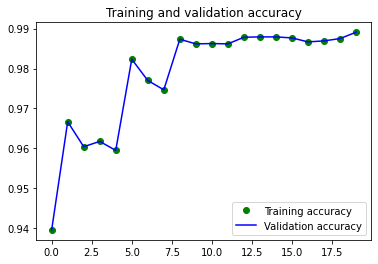

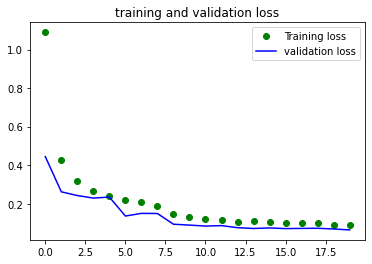

In [163]:
accuracy = model_fit.history['accuracy']
val_accuracy = model_fit.history['val_accuracy']

loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

epochs = range(len(val_accuracy))
plt.plot(epochs, val_accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

## Classification Report

In [164]:
print(classification_report(ytest,predicted))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.99      1.00       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Confusion Matrix

Text(91.68, 0.5, 'predicted data')

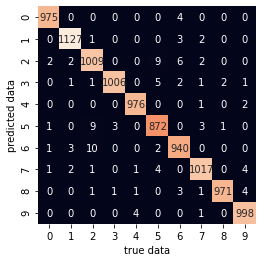

In [165]:
mat = confusion_matrix(ytest, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true data')
plt.ylabel('predicted data')